<a href="https://colab.research.google.com/github/ItayShalit/Intro-to-Deep-Learning/blob/main/NNRegression_Intro_to_DL_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install --upgrade git+https://github.com/noahgolmant/pytorch-hessian-eigenthings.git@master#egg=hessian-eigenthings
# !pip uninstall numpy
# !pip install numpy
!pip install pyhessian
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# from hessian_eigenthings import compute_hessian_eigenthings
from pyhessian import hessian
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch.utils.data as data_utils
from matplotlib import pyplot as plt
from collections import OrderedDict
from sklearn.datasets import make_regression
from google.colab import files
from math import pi, acos


Data Generation

In [2]:
RANDOM_STATE = 10
x,y = make_regression(100000, 10, random_state = RANDOM_STATE, noise = 0.1)
df = pd.DataFrame(x)
df['y'] = y
train, test = train_test_split(df, test_size = 0.25, random_state = 10)

#Part 2

In [3]:
batch_size = len(train)

test_target = torch.tensor(test['y'].values.astype(np.float32))#
test_target = torch.unsqueeze(test_target, dim = 1)
train_target = torch.tensor(train['y'].values.astype(np.float32))
train_target = torch.unsqueeze(train_target, dim = 1)
test = torch.tensor(test.drop('y', axis = 1).values.astype(np.float32))
train = torch.tensor(train.drop('y', axis = 1).values.astype(np.float32))

train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

In [4]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        print(loss)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")

def calculate_gradient_l2_norm(model):
    mean_l2_norm = 0
    grad_num = 0
    for p in list(filter(lambda p: p.grad is not None, model.parameters())):
        grad_num += len(p)
    for p in list(filter(lambda p: p.grad is not None, model.parameters())):
        mean_l2_norm += (p.grad.data.norm(2).item())*(len(p)/grad_num)
    return mean_l2_norm

def init_weights_normal(model, init_std):
  for m in model.modules():
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
      torch.nn.init.normal_(m.weight, mean=0.0, std=init_std)
      if m.bias is not None:
        torch.nn.init.normal_(m.bias, mean=0.0, std=init_std)

In [ ]:
HIDDEN_SIZE = 16
PLOTTING_PARAM = 100



class linearRegression(torch.nn.Module):
    def __init__(self, depth, inputSize, outputSize, hiddenSize):
        super(linearRegression, self).__init__()
        # self.bn = torch.nn.BatchNorm1d(num_features=1)
        self.layers = nn.ModuleList()
        self.layers.append(torch.nn.Linear(inputSize, hiddenSize))
        # self.linear2 = torch.nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        for i in range(depth-1):
          self.layers.append(torch.nn.Linear(hiddenSize, hiddenSize))
        self.layers.append(torch.nn.Linear(hiddenSize, outputSize))

    def forward(self, inx):
        # x = self.bn(inx) # Adding BN to standardize input helps us use a higher learning rate
        x = inx
        for layer in self.layers:
          x = layer(x)
        # x = self.linear2(x)
        return x


epochs = 2000    
mseloss = F.mse_loss
lr = 10e-7
init_std = 10e-1

PLOTTING_PARAM = 200
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

test_cpu = test
train_cpu = train
test_target_cpu = test_target
train_target_cpu = train_target

for depth in [2,3,4]:
  torch.cuda.empty_cache()
  test = test_cpu.to(device)
  train = train_cpu.to(device)
  test_target = test_target_cpu.to(device)
  train_target = train_target_cpu.to(device)
  loss_values, loss_grad_l2_norm, min_eigenvalues_of_hessian, max_eigenvalues_of_hessian  = [], [], [], []    
  model = linearRegression(depth, 10, 1, 16)    
  model = model.to(device) 
  init_weights_normal(model, init_std)
  for epoch in range(epochs):
      loss_values.append(mseloss(test_target, model(test)))
      loss_grad_l2_norm.append(calculate_gradient_l2_norm(model))  
      model.train()
      optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
      optimizer.zero_grad()
      loss = mseloss(train_target, model(train))  
      loss.backward()
      optimizer.step()
      if epoch%PLOTTING_PARAM == 0:
        print(f'epoch {epoch}, loss {loss_values[-1]}, train loss {mseloss(train_target, model(train))}, gradient norm {loss_grad_l2_norm[-1]}')   
        eigenvals, eigenvecs = compute_hessian_eigenthings(model, train_loader, mseloss, 2)
        min_eigenvalues_of_hessian.append(min(eigenvals))
        max_eigenvalues_of_hessian.append(max(eigenvals)) 

  data = pd.DataFrame()
  data['loss'] = pd.Series(torch.tensor(loss_values, device = 'cpu'))
  data['loss_grad_norm'] = pd.Series(torch.tensor(loss_grad_l2_norm, device = 'cpu'))
  data['min_hessian_eigenvalue'] = pd.Series(torch.tensor(min_eigenvalues_of_hessian, device = 'cpu'))
  data['max_hessian_eigenvalue'] = pd.Series(torch.tensor(max_eigenvalues_of_hessian, device = 'cpu'))
  data.to_csv(f'training depth {depth} part 2.csv')
    

Using cuda device


NameError: ignored

Experimental Vesrion (Delete Before Handing In)

In [5]:
HIDDEN_SIZE = 16
PLOTTING_PARAM = 100

class linearRegression(torch.nn.Module):
    def __init__(self, depth, inputSize, outputSize, hiddenSize):
        super(linearRegression, self).__init__()
        # self.bn = torch.nn.BatchNorm1d(num_features=1)
        self.layers = nn.ModuleList()
        self.layers.append(torch.nn.Linear(inputSize, hiddenSize))
        # self.linear2 = torch.nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        for i in range(depth-2):
          self.layers.append(torch.nn.Linear(hiddenSize, hiddenSize))
        self.layers.append(torch.nn.Linear(hiddenSize, outputSize))

    def forward(self, inx):
        # x = self.bn(inx) # Adding BN to standardize input helps us use a higher learning rate
        x = inx
        for layer in self.layers:
          x = layer(x)
        # x = self.linear2(x)
        return x


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [10]:
test_cpu = test
train_cpu = train
test_target_cpu = test_target
train_target_cpu = train_target

test = test_cpu.to(device)
train = train_cpu.to(device)
test_target = test_target_cpu.to(device)
train_target = train_target_cpu.to(device)

In [16]:
epochs = 2500    
mseloss = F.mse_loss
lr = 10e-7
init_std = 10e-1

#Depth 2: lr, init_std =  10e-5, 10e-1
#Depth 3: lr, init_std =  10e-2, 10e-5
#Depth 3: lr, init_std =  10e-1, 10e-7
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

all_loss_values, all_loss_grad_l2_norm, all_min_eigenvalues_of_hessian, all_max_eigenvalues_of_hessian  = [], [], [], []    
PLOTTING_PARAM = 300

#Depth 2 net:

test_cpu = test
train_cpu = train
test_target_cpu = test_target
train_target_cpu = train_target


for depth in [2,3,4]:
  torch.cuda.empty_cache()
  test = test_cpu.to(device)
  train = train_cpu.to(device)
  test_target = test_target_cpu.to(device)
  train_target = train_target_cpu.to(device)
  loss_values, loss_grad_l2_norm, min_eigenvalues_of_hessian, max_eigenvalues_of_hessian  = [], [], [], []    
  # train = train.to(device)
  # test = test.to(device)
  # test_target = test_target.to(device)
  # train_target = train_target.to(device)
  model = linearRegression(depth, 10, 1, 16)    
  model = model.to(device) 
  init_weights_normal(model, init_std)
  for epoch in range(epochs):
      loss_values.append(mseloss(test_target, model(test)))
      loss_grad_l2_norm.append(calculate_gradient_l2_norm(model))  
      model.train()
      optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0)
      
      # model.to(device)
      optimizer.zero_grad()
      # outputs = model(train)
      # model.eval()
      # loss = mseloss(train_target, model(train))
      loss = mseloss(train_target, model(train))  
      loss.backward()
      optimizer.step()
      # scheduler.step()
      # test.to(device)
      if epoch%PLOTTING_PARAM == 0:
        print(f'epoch {epoch}, loss {loss_values[-1]}, train loss {mseloss(train_target, model(train))}, gradient norm {loss_grad_l2_norm[-1]}') 
        hessian_comp = hessian(model, F.mse_loss, data=(train, train_target), cuda=True)
        top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=15)
      #   eigenvals, eigenvecs = compute_hessian_eigenthings(model, train_loader, mseloss, 2)
        min_eigenvalues_of_hessian.append(min(top_eigenvalues))
        max_eigenvalues_of_hessian.append(max(top_eigenvalues)) 
      # else:
      #   min_eigenvalues_of_hessian.append(min_eigenvalues_of_hessian[-1])
      #   max_eigenvalues_of_hessian.append(max_eigenvalues_of_hessian[-1])
  data = pd.DataFrame()
  data['loss'] = pd.Series(torch.tensor(loss_values, device = 'cpu'))
  data['loss_grad_norm'] = pd.Series(torch.tensor(loss_grad_l2_norm, device = 'cpu'))
  data['min_hessian_eigenvalue'] = pd.Series(torch.tensor(min_eigenvalues_of_hessian, device = 'cpu'))
  data['max_hessian_eigenvalue'] = pd.Series(torch.tensor(max_eigenvalues_of_hessian, device = 'cpu'))


  data.to_csv(f'training depth {depth} part 2 ver2.csv')
  files.download(f'training depth {depth} part 2 ver2.csv')

  # all_loss_values.append(loss_values)
  # all_loss_grad_l2_norm.append(loss_grad_l2_norm)
  # all_min_eigenvalues_of_hessian.append(min_eigenvalues_of_hessian)
  # all_max_eigenvalues_of_hessian.append(max_eigenvalues_of_hessian)
  print(f"finished with depth {depth}")
        

epoch 0, loss 17054.158203125, train loss 17168.5703125, gradient norm 0
epoch 300, loss 16263.1240234375, train loss 16369.2939453125, gradient norm 568.1406726977403
epoch 600, loss 15486.91796875, train loss 15584.9423828125, gradient norm 566.4820063745275
epoch 900, loss 14711.4462890625, train loss 14801.3603515625, gradient norm 569.3175849493813
epoch 1200, loss 13926.294921875, train loss 14008.09375, gradient norm 575.2652946044416
epoch 1500, loss 13124.3935546875, train loss 13198.0771484375, gradient norm 583.017853610656
epoch 1800, loss 12301.892578125, train loss 12367.4814453125, gradient norm 591.3515899111243
epoch 2100, loss 11458.0634765625, train loss 11515.6337890625, gradient norm 599.1355160211816
epoch 2400, loss 10595.2275390625, train loss 10644.931640625, gradient norm 605.4049788025372


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

finished with depth 2
epoch 0, loss 16288.4599609375, train loss 16324.47265625, gradient norm 0
epoch 300, loss 7712.68701171875, train loss 7732.6640625, gradient norm 1313.43424802838
epoch 600, loss 2692.353759765625, train loss 2695.545654296875, gradient norm 1055.7202627586596
epoch 900, loss 676.6342163085938, train loss 675.7484741210938, gradient norm 632.889484983502
epoch 1200, loss 149.74713134765625, train loss 149.09793090820312, gradient norm 319.56181059461653
epoch 1500, loss 33.59741973876953, train loss 33.350154876708984, gradient norm 153.31896658377215
epoch 1800, loss 8.03265380859375, train loss 7.951870918273926, gradient norm 73.74623248793863
epoch 2100, loss 2.0738489627838135, train loss 2.048388719558716, gradient norm 36.25840040047964
epoch 2400, loss 0.5799074172973633, train loss 0.5718531608581543, gradient norm 18.329508284727734


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

finished with depth 3
epoch 0, loss 37666.3828125, train loss 34412.078125, gradient norm 0
epoch 300, loss 42.372215270996094, train loss 42.0629768371582, gradient norm 254.41705756528037
epoch 600, loss 0.06684901565313339, train loss 0.06616897881031036, gradient norm 9.069622903016908
epoch 900, loss 0.010116113349795341, train loss 0.010073448531329632, gradient norm 0.43257554438041174
epoch 1200, loss 0.009982841089367867, train loss 0.009952829219400883, gradient norm 0.06477232801143498
epoch 1500, loss 0.009979680180549622, train loss 0.009950871579349041, gradient norm 0.03154043109531571
epoch 1800, loss 0.009979412890970707, train loss 0.009950672276318073, gradient norm 0.024364154914165936
epoch 2100, loss 0.009979289025068283, train loss 0.009950583800673485, gradient norm 0.0205064126624778
epoch 2400, loss 0.009979208931326866, train loss 0.00995055865496397, gradient norm 0.01716754887412226


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

finished with depth 4


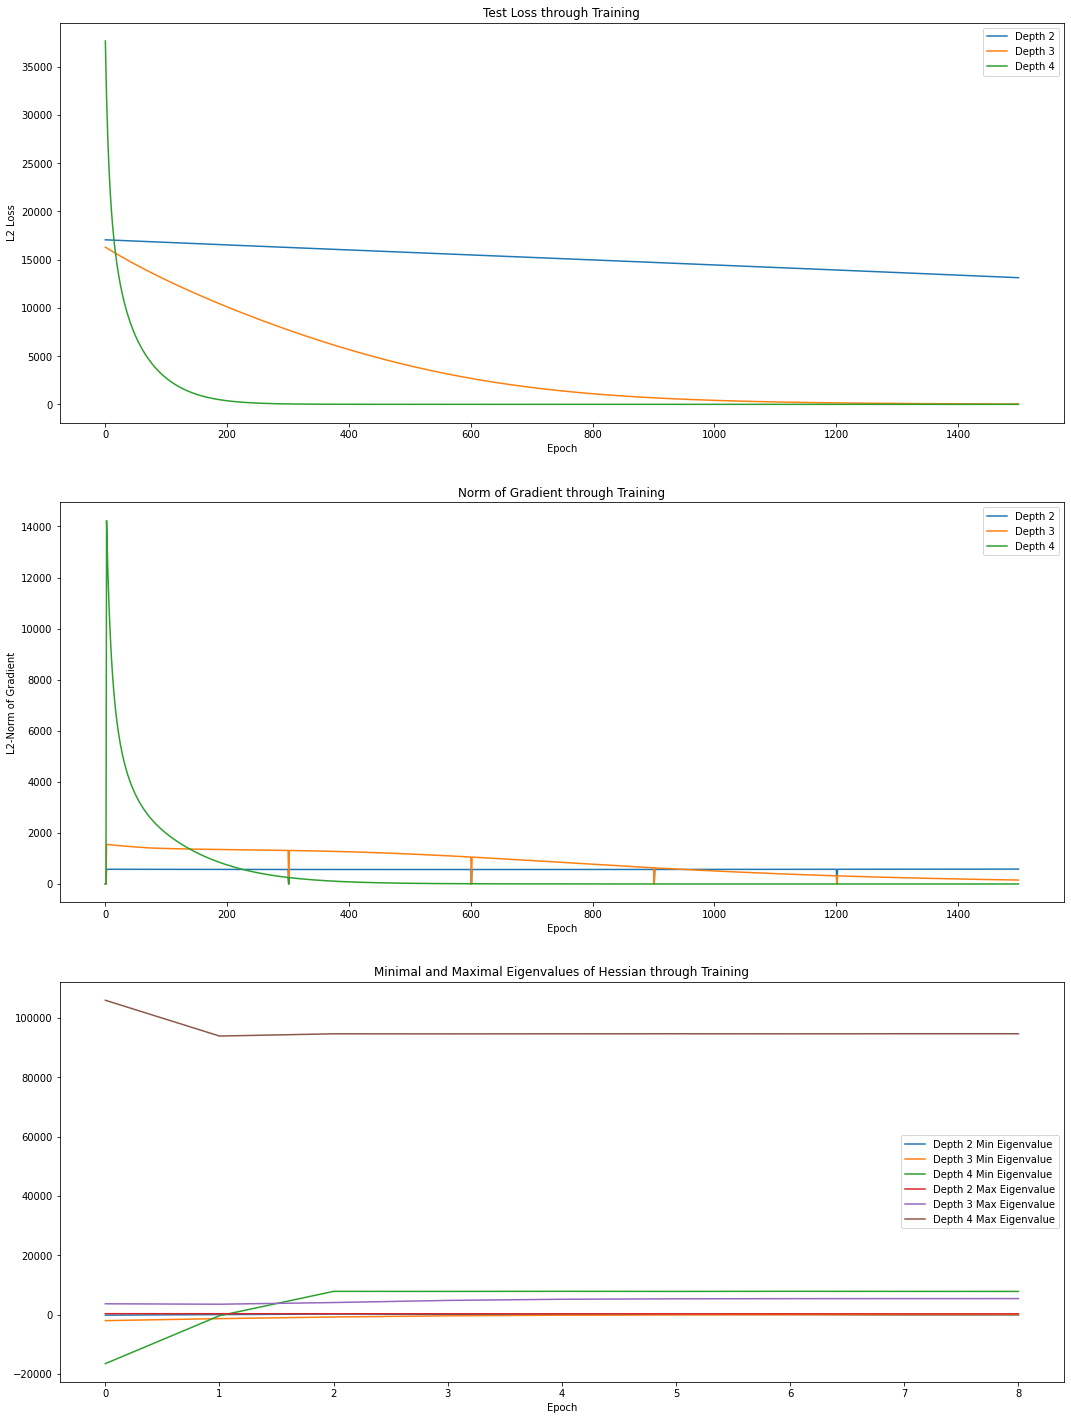

In [18]:

depth2 = pd.read_csv(f'training depth 2 part 2 ver2.csv').iloc[:1500]
depth3 = pd.read_csv(f'training depth 3 part 2 ver2.csv').iloc[:1500]
depth4 = pd.read_csv(f'training depth 4 part 2 ver2.csv').iloc[:1500]
# depth4 = pd.read_csv(f'training depth 4 part 2.csv').iloc[:1500]

fig = plt.figure(figsize = (18, 25))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

ax1.plot([i for i in range(len(depth2))], depth2.loss, label = 'Depth 2')
ax1.plot([i for i in range(len(depth3))], depth3.loss, label = 'Depth 3')
ax1.plot([i for i in range(len(depth4))], depth4.loss, label = 'Depth 4')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('L2 Loss')
ax1.set_title('Test Loss through Training')
ax1.legend()

ax2.plot([i for i in range(len(depth2))], depth2.loss_grad_norm, label = 'Depth 2')
ax2.plot([i for i in range(len(depth3))], depth3.loss_grad_norm, label = 'Depth 3')
ax2.plot([i for i in range(len(depth4))], depth4.loss_grad_norm, label = 'Depth 4')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('L2-Norm of Gradient')
ax2.set_title('Norm of Gradient through Training')
ax2.legend()

ax3.plot([i for i in range(len(depth2))], depth2.min_hessian_eigenvalue, label = 'Depth 2 Min Eigenvalue')
ax3.plot([i for i in range(len(depth3))], depth3.min_hessian_eigenvalue, label = 'Depth 3 Min Eigenvalue')
ax3.plot([i for i in range(len(depth4))], depth4.min_hessian_eigenvalue, label = 'Depth 4 Min Eigenvalue')
ax3.plot([i for i in range(len(depth2))], depth2.max_hessian_eigenvalue, label = 'Depth 2 Max Eigenvalue')
ax3.plot([i for i in range(len(depth3))], depth3.max_hessian_eigenvalue, label = 'Depth 3 Max Eigenvalue')
ax3.plot([i for i in range(len(depth4))], depth4.max_hessian_eigenvalue, label = 'Depth 4 Max Eigenvalue')
ax3.set_xlabel('Epoch')
ax3.set_title('Minimal and Maximal Eigenvalues of Hessian through Training')
ax3.legend()

# Part 3

In [ ]:
train, test = train_test_split(df, test_size = 0.25, random_state = 10)

x_train = np.array(train.drop('y', axis = 1))
x_test = np.array(test.drop('y', axis = 1))
y_train = np.array(train['y'])
y_test = np.array(test['y'])

inputSize = 10
lr = 10e-7
epochs = 10000

In [ ]:
from sklearn.metrics import mean_squared_error


all_loss_values = []


for N in [2,3]:
  loss_values = []
  w = np.random.normal(0, 10e-1, 10).reshape(-1,1)
  for t in range(epochs):  
    loss_grad = (np.dot(np.transpose(x_train), np.dot(x_train,w) - y_train.reshape(-1,1)))*(2/(x_train.size))
    loss_values.append(mean_squared_error(y_test, np.dot(x_test,w)))
    update = np.zeros(w.shape)
    u1, s1, v1 = np.linalg.svd(np.dot(w.reshape(-1,1), np.transpose(w.reshape(-1,1))))
    u2, s2, v2 = np.linalg.svd(np.dot(np.transpose(w.reshape(-1,1)), w.reshape(-1,1)))
    for j in (1, N+1):
      s1_exp = np.power(s1, (j-1)/N) 
      s2_exp = np.power(s2, (N-j)/N)
      e1 = np.linalg.multi_dot([u1, np.diag(s1_exp), np.transpose(u1)])
      e2 = np.linalg.multi_dot([v2, np.diag(s2_exp), np.transpose(v2)])
      
      # e1 = np.linalg.multi_dot([u, s, np.transpose(u)])
      # e2 = np.linalg.multi_dot([v, s, np.transpose(v)])

      update += np.linalg.multi_dot([e1, loss_grad.reshape(-1,1), e2])
      # print(update.shape)
    # print("w shape: ", w.shape)
    w = w - lr*update
    # print("w shape: ", w.shape)
  all_loss_values.append(loss_values)
    

    # e1 = torch.linalg.matrix_power(torch.tensor(np.dot(w.reshape(-1,1), np.transpose(w.reshape(-1,1)))), (j-1)/N)
    # e2 = torch.pow(np.dot(np.transpose(w.reshape(-1,1)), w.reshape(-1,1)), (j-1)/N)

In [ ]:
depth2 = pd.read_csv(f'training depth 2 part 2 ver2.csv')
depth3 = pd.read_csv(f'training depth 2 part 2.csv')

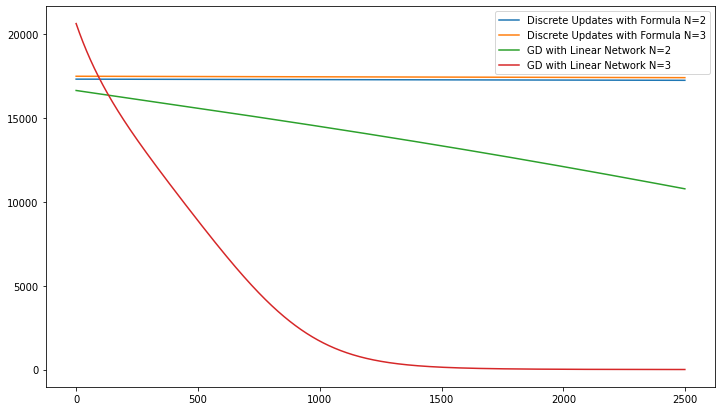

In [ ]:
fig = plt.figure(figsize = (12,7))
ax = fig.add_subplot(1,1,1)
ax.plot([i for i in range(len(all_loss_values[0][:2500]))], all_loss_values[0][:2500], label = 'Discrete Updates with Formula N=2')
ax.plot([i for i in range(len(all_loss_values[1][:2500]))], all_loss_values[1][:2500], label = 'Discrete Updates with Formula N=3')
ax.plot([i for i in range(len(depth2.loss))], depth2.loss, label = 'GD with Linear Network N=2')
ax.plot([i for i in range(len(depth3.loss))], depth3.loss, label = 'GD with Linear Network N=3')
ax.legend()


# Part 4

In [3]:
class TangentKernelNet(torch.nn.Module):
    def __init__(self, inputSize, hiddenSize):
        super(TangentKernelNet, self).__init__()
        self.input_layer = torch.nn.Linear(inputSize, hiddenSize)
        torch.nn.init.normal_(self.input_layer.weight, mean = 0.0, std = 1.0)
        self.relu = nn.ReLU()
        self.output_layer = torch.nn.Linear(hiddenSize, 1)
        w = np.ones(hiddenSize)
        w[:int(hiddenSize*0.5)] = -1.
        np.random.shuffle(w)
        self.output_layer.weight = nn.Parameter(torch.tensor(w).type(torch.FloatTensor).reshape(1,-1))

    def forward(self, inx):
        x = self.input_layer(inx)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

In [4]:
RANDOM_STATE = 10

x,y = make_regression(1000, 10, random_state = RANDOM_STATE, noise = 0.1) #We use a smaller dataset here for computational reasons.
df = pd.DataFrame(x)
df['y'] = y

train, test = train_test_split(df, test_size = 0.25, random_state = 10)
batch_size = len(train)
test_target = torch.tensor(test['y'].values.astype(np.float32))#
test_target = torch.unsqueeze(test_target, dim = 1)
train_target = torch.tensor(train['y'].values.astype(np.float32))
train_target = torch.unsqueeze(train_target, dim = 1)
test = torch.tensor(test.drop('y', axis = 1).values.astype(np.float32))
train = torch.tensor(train.drop('y', axis = 1).values.astype(np.float32))

train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

In [7]:
HIDDEN_SIZE = 16
PLOTTING_PARAM = 100



class linearRegression(torch.nn.Module):
    def __init__(self, depth, inputSize, outputSize, hiddenSize):
        super(linearRegression, self).__init__()
        # self.bn = torch.nn.BatchNorm1d(num_features=1)
        self.layers = nn.ModuleList()
        self.layers.append(torch.nn.Linear(inputSize, hiddenSize))
        # self.linear2 = torch.nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        for i in range(depth-1):
          self.layers.append(torch.nn.Linear(hiddenSize, hiddenSize))
        self.layers.append(torch.nn.Linear(hiddenSize, outputSize))

    def forward(self, inx):
        # x = self.bn(inx) # Adding BN to standardize input helps us use a higher learning rate
        x = inx
        for layer in self.layers:
          x = layer(x)
        # x = self.linear2(x)
        return x

class TangentKernelNet(torch.nn.Module):
    def __init__(self, inputSize, hiddenSize):
        super(TangentKernelNet, self).__init__()
        self.input_layer = torch.nn.Linear(inputSize, hiddenSize)
        torch.nn.init.normal_(self.input_layer.weight, mean = 0.0, std = 1.0)
        self.relu = nn.ReLU()
        self.output_layer = torch.nn.Linear(hiddenSize, 1)
        w = np.ones(hiddenSize)
        w[:int(hiddenSize*0.5)] = -1.
        np.random.shuffle(w)
        self.output_layer.weight = nn.Parameter(torch.tensor(w).type(torch.FloatTensor).reshape(1,-1))

    def forward(self, inx):
        x = self.input_layer(inx)
        x = self.relu(x)
        x = self.output_layer(x)
        return x


epochs = 15000    

mseloss = F.mse_loss
lr = 10e-7
init_std = 10e-1

PLOTTING_PARAM = 200
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

test_cpu = test
train_cpu = train
test_target_cpu = test_target
train_target_cpu = train_target

# all_loss_values = []

widths = [4, 32, 128, 512]
widths = [32, 128, 512]
widths = [4]

for width in widths:
  torch.cuda.empty_cache()
  test = test_cpu.to(device)
  train = train_cpu.to(device)
  test_target = test_target_cpu.to(device)
  train_target = train_target_cpu.to(device)
  loss_values =  []    
  # model = linearRegression(depth, 10, 1, 16)    
  model = TangentKernelNet(10, width)
  model = model.to(device) 
  for epoch in range(epochs):
      loss_values.append(mseloss(test_target, model(test)))
      model.train()
      optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
      optimizer.zero_grad()
      loss = mseloss(train_target, model(train))  
      loss.backward()
      optimizer.step()
      if epoch%PLOTTING_PARAM == 0:
        print(f'epoch {epoch}, loss {loss_values[-1]}')   
  all_loss_values.append(loss_values)
  # data = pd.DataFrame()
  # data['loss'] = pd.Series(torch.tensor(loss_values, device = 'cpu'))
  # data.to_csv(f'question 4 width {width}.csv')
  # files.download(f'question 4 width {width}.csv')


Using cuda device
epoch 0, loss 47571.6953125
epoch 200, loss 47517.5546875
epoch 400, loss 47464.359375
epoch 600, loss 47411.75
epoch 800, loss 47359.10546875
epoch 1000, loss 47306.71875
epoch 1200, loss 47253.69140625
epoch 1400, loss 47199.69921875
epoch 1600, loss 47144.390625
epoch 1800, loss 47087.73046875
epoch 2000, loss 47029.69921875
epoch 2200, loss 46969.2578125
epoch 2400, loss 46905.890625
epoch 2600, loss 46839.53125
epoch 2800, loss 46770.2421875
epoch 3000, loss 46696.77734375
epoch 3200, loss 46618.25
epoch 3400, loss 46534.23828125
epoch 3600, loss 46444.94140625
epoch 3800, loss 46349.25
epoch 4000, loss 46245.921875
epoch 4200, loss 46133.703125
epoch 4400, loss 46013.265625
epoch 4600, loss 45883.00390625
epoch 4800, loss 45742.35546875
epoch 5000, loss 45589.546875
epoch 5200, loss 45421.11328125
epoch 5400, loss 45237.5625
epoch 5600, loss 45039.51171875
epoch 5800, loss 44825.4609375
epoch 6000, loss 44592.31640625
epoch 6200, loss 44337.125
epoch 6400, loss 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
train, test = train_test_split(df, test_size = 0.25, random_state = 10)

test_target = np.array(test['y'].values.astype(np.float32))#
test_target = np.array(test_target).reshape(-1,1)
train_target = np.array(train['y'].values.astype(np.float32))
train_target = np.array(train_target).reshape(-1,1)
test = np.array(test.drop('y', axis = 1).values.astype(np.float32)).transpose()
train = np.array(train.drop('y', axis = 1).values.astype(np.float32)).transpose()


In [11]:
np.random.RandomState(seed=RANDOM_STATE)


u = np.random.normal(loc=0.0, scale=0.001, size=train.shape[1]).reshape(train.shape[1], 1)
lr = 10e-7
epochs = 1500

gram = np.dot(train.transpose(), train)
norms = np.linalg.norm(train, axis = 0 , ord= 2).reshape(-1,1)
norm_products = np.dot(norms, norms.transpose())
quotient = np.divide(gram, norm_products)
quotient[quotient > 1] = 1.0 #Fixing a problem caused by numerical inaccuracies.
h_star = np.dot(gram,(pi - np.arccos(quotient)))/(2*pi)

analytic_loss_values = []

for i in range(epochs):
  analytic_loss_values.append(np.linalg.norm(train_target - u, ord = 2))
  u_grad = -np.dot(h_star, u - train_target)
  u = u + (u_grad*lr)
  if i%15 == 0:
    print(f"epoch: {i}, loss: {analytic_loss_values[-1]}")


epoch: 0, loss: 5451.27317549642
epoch: 15, loss: 4781.906451095223
epoch: 30, loss: 4199.954198955353
epoch: 45, loss: 3693.3436056614755
epoch: 60, loss: 3251.7442587461787
epoch: 75, loss: 2866.3092697875472
epoch: 90, loss: 2529.455442187121
epoch: 105, loss: 2234.6765634290023
epoch: 120, loss: 1976.384801187223
epoch: 135, loss: 1749.775944718778
epoch: 150, loss: 1550.7148788378297
epoch: 165, loss: 1375.6382253637507
epoch: 180, loss: 1221.4715514063676
epoch: 195, loss: 1085.558937954746
epoch: 210, loss: 965.6030367285416
epoch: 225, loss: 859.6140272081122
epoch: 240, loss: 765.8661268424961
epoch: 255, loss: 682.8605121178412
epoch: 270, loss: 609.2936819318909
epoch: 285, loss: 544.030442205248
epoch: 300, loss: 486.0808158065627
epoch: 315, loss: 434.5802880232275
epoch: 330, loss: 388.7728878180547
epoch: 345, loss: 347.9966813988878
epoch: 360, loss: 311.67131925613626
epoch: 375, loss: 279.28733255146204
epoch: 390, loss: 250.3969210677565
epoch: 405, loss: 224.6060141

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


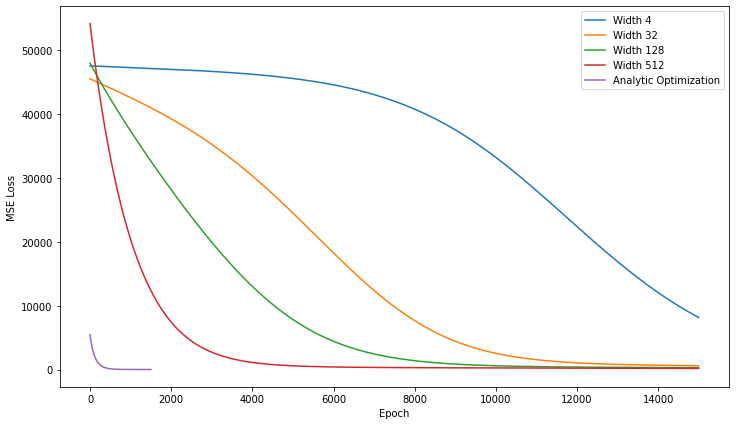

In [15]:
for i in range(len(all_loss_values)):
  all_loss_values[i] = torch.tensor(all_loss_values[i]).cpu()
fig = plt.figure(figsize = (12,7))
ax = fig.add_subplot(1,1,1)
ax.plot([i for i in range(len(all_loss_values[3]))], all_loss_values[3], label = 'Width 4')
ax.plot([i for i in range(len(all_loss_values[0]))], all_loss_values[0], label = 'Width 32')
ax.plot([i for i in range(len(all_loss_values[1]))], all_loss_values[1], label = 'Width 128')
ax.plot([i for i in range(len(all_loss_values[2]))], all_loss_values[2], label = 'Width 512')
ax.plot([i for i in range(len(analytic_loss_values))], analytic_loss_values, label = 'Analytic Optimization')

ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.legend()
